In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import plotly.express as px
import joblib
import tensorflow as tf
import os
from tensorflow.keras.models import load_model

sns.set()
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.preprocessing.sequence import TimeseriesGenerator



from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [102]:
storeFirstDataframeFeatureDates = pd.read_csv('./rawData/data_prueba_Forecasting_Large_Dataframe.csv')

In [103]:
storeFirstDataframeFeatureDates.head()

,Unnamed: 0,Tienda,Producto,id_fec_diaria,Venta,Precio,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek
0,0,1,369772,2020-08-01,5.0,21.063200,8,1,2020,0,1,1,0,0,5
1,1,1,369772,2020-08-02,3.0,21.388667,8,2,2020,0,1,1,0,0,6
2,2,1,369772,2020-08-03,5.0,21.376199,8,3,2020,0,1,1,0,0,0
3,3,1,369772,2020-08-04,3.0,21.360367,8,4,2020,0,1,1,0,0,1
4,4,1,369772,2020-08-05,1.0,21.397100,8,5,2020,0,1,1,0,0,2


In [104]:
storeFirstDataframeFeatureDates=storeFirstDataframeFeatureDates.drop(['Unnamed: 0'], axis=1)

In [105]:
storeFirstDataframeFeatureDates['id_fec_diaria'] = pd.to_datetime(storeFirstDataframeFeatureDates['id_fec_diaria']) 

In [106]:
storeFirstDataframeFeatureDates

,Tienda,Producto,id_fec_diaria,Venta,Precio,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek
0,1,369772,2020-08-01,5.0,21.063200,8,1,2020,0,1,1,0,0,5
1,1,369772,2020-08-02,3.0,21.388667,8,2,2020,0,1,1,0,0,6
2,1,369772,2020-08-03,5.0,21.376199,8,3,2020,0,1,1,0,0,0
3,1,369772,2020-08-04,3.0,21.360367,8,4,2020,0,1,1,0,0,1
4,1,369772,2020-08-05,1.0,21.397100,8,5,2020,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852749,1,2098857,2021-10-27,8.0,27.003750,10,27,2021,0,1,0,0,1,2
852750,1,2098857,2021-10-28,18.0,26.911667,10,28,2021,0,1,0,0,1,3
852751,1,2098857,2021-10-29,13.0,24.463077,10,29,2021,0,1,0,0,1,4
852752,1,2098857,2021-10-30,17.0,25.404118,10,30,2021,0,1,0,0,1,5


Se planea utilizar dos modelos. Primero, algo simple como lo es ARIMA. Después, un modelo más complejo como lo es un modelo LSTM. El primero nos permite trabajar con menor cantidad de información. Para el segundo se requiere una mayor cantidad de información pero puede retener información del pasado para hacer las predicciones.

Para la primera parte, debo hacer un split del dataset, usando para el training desde agosto 1 del año anterior hasta finales de septiembre del 2020, y los mismos meses pero del año 2021. Para testear el modelo, se usará del 1 al 31 de octubre del 2020 y del 1 al 14 de octubre del 2021. Luego, del 15 al 31 se tomará para el pronóstico. Esto para el punto b.  

Para la segunda parte, se ejecutará el modelo con la información de noviembre, una vez perfeccionado el entrenamiento del mismo con la información de los dataset anteriormente segmentados

In [107]:
storeFirstDataframeFeatureDates

,Tienda,Producto,id_fec_diaria,Venta,Precio,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek
0,1,369772,2020-08-01,5.0,21.063200,8,1,2020,0,1,1,0,0,5
1,1,369772,2020-08-02,3.0,21.388667,8,2,2020,0,1,1,0,0,6
2,1,369772,2020-08-03,5.0,21.376199,8,3,2020,0,1,1,0,0,0
3,1,369772,2020-08-04,3.0,21.360367,8,4,2020,0,1,1,0,0,1
4,1,369772,2020-08-05,1.0,21.397100,8,5,2020,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852749,1,2098857,2021-10-27,8.0,27.003750,10,27,2021,0,1,0,0,1,2
852750,1,2098857,2021-10-28,18.0,26.911667,10,28,2021,0,1,0,0,1,3
852751,1,2098857,2021-10-29,13.0,24.463077,10,29,2021,0,1,0,0,1,4
852752,1,2098857,2021-10-30,17.0,25.404118,10,30,2021,0,1,0,0,1,5


In [108]:
column_order = ['Venta'] + [col for col in storeFirstDataframeFeatureDates.columns if col != 'Venta']
storeFirstDataframeFeatureDates = storeFirstDataframeFeatureDates[column_order]

In [109]:
storeFirstDataframeFeatureDates

,Venta,Tienda,Producto,id_fec_diaria,Precio,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek
0,5.0,1,369772,2020-08-01,21.063200,8,1,2020,0,1,1,0,0,5
1,3.0,1,369772,2020-08-02,21.388667,8,2,2020,0,1,1,0,0,6
2,5.0,1,369772,2020-08-03,21.376199,8,3,2020,0,1,1,0,0,0
3,3.0,1,369772,2020-08-04,21.360367,8,4,2020,0,1,1,0,0,1
4,1.0,1,369772,2020-08-05,21.397100,8,5,2020,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852749,8.0,1,2098857,2021-10-27,27.003750,10,27,2021,0,1,0,0,1,2
852750,18.0,1,2098857,2021-10-28,26.911667,10,28,2021,0,1,0,0,1,3
852751,13.0,1,2098857,2021-10-29,24.463077,10,29,2021,0,1,0,0,1,4
852752,17.0,1,2098857,2021-10-30,25.404118,10,30,2021,0,1,0,0,1,5


In [110]:
training_start = '2020-08-01'
training_end = '2020-10-31'
testing_start = '2021-10-15'
testing_end = '2021-10-31'
#validation_start = '2021-10-15'
#validation_end = '2021-10-31'

training_data = storeFirstDataframeFeatureDates[
    ((storeFirstDataframeFeatureDates['id_fec_diaria'] >= training_start) & (storeFirstDataframeFeatureDates['id_fec_diaria'] <= training_end)) |
    ((storeFirstDataframeFeatureDates['id_fec_diaria'] >= '2021-08-01') & (storeFirstDataframeFeatureDates['id_fec_diaria'] <= '2021-10-14'))
]

testing_data = storeFirstDataframeFeatureDates[
    ((storeFirstDataframeFeatureDates['id_fec_diaria'] >= testing_start) & (storeFirstDataframeFeatureDates['id_fec_diaria'] <= testing_end))  
]

#validation_data = storeFirstDataframeFeatureDates[
 #   (storeFirstDataframeFeatureDates['id_fec_diaria'] >= validation_start) & (storeFirstDataframeFeatureDates['id_fec_diaria'] <= validation_end)
#]

In [111]:
training_data

,Venta,Tienda,Producto,id_fec_diaria,Precio,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek
0,5.0,1,369772,2020-08-01,21.063200,8,1,2020,0,1,1,0,0,5
1,3.0,1,369772,2020-08-02,21.388667,8,2,2020,0,1,1,0,0,6
2,5.0,1,369772,2020-08-03,21.376199,8,3,2020,0,1,1,0,0,0
3,3.0,1,369772,2020-08-04,21.360367,8,4,2020,0,1,1,0,0,1
4,1.0,1,369772,2020-08-05,21.397100,8,5,2020,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852732,16.0,1,2098857,2021-10-10,27.101251,10,10,2021,0,1,0,0,1,6
852733,21.0,1,2098857,2021-10-11,26.985715,10,11,2021,0,1,0,0,1,0
852734,19.0,1,2098857,2021-10-12,26.776316,10,12,2021,0,1,0,0,1,1
852735,11.0,1,2098857,2021-10-13,26.741818,10,13,2021,0,1,0,0,1,2


In [112]:
print(testing_data.shape)
print(training_data.shape)

(78769, 14)
(773985, 14)


In [113]:
columnsToScale = ['Tienda', 'Producto', 'Mes', 'Day', 'Year', 'Formato_Hiper', 'Formato_Super', 'Subformato_Basico', 'Subformato_Intermedio', 'Subformato_Plus', 'DayOfWeek']
featureDataFrame_training = training_data[columnsToScale]
featureDataFrame_testing = testing_data[columnsToScale]

x_training = training_data[columnsToScale]
x_testing = testing_data[columnsToScale]
y_training = training_data[['Venta']]
y_testing = testing_data[['Venta']]

featureDataFrame_training['Venta'] = training_data['Venta']

C:\Users\alan_\AppData\Local\Temp\ipykernel_41796\3348126388.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureDataFrame_training['Venta'] = training_data['Venta']


In [114]:
featureDataFrame_training

,Tienda,Producto,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek,Venta
0,1,369772,8,1,2020,0,1,1,0,0,5,5.0
1,1,369772,8,2,2020,0,1,1,0,0,6,3.0
2,1,369772,8,3,2020,0,1,1,0,0,0,5.0
3,1,369772,8,4,2020,0,1,1,0,0,1,3.0
4,1,369772,8,5,2020,0,1,1,0,0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
852732,1,2098857,10,10,2021,0,1,0,0,1,6,16.0
852733,1,2098857,10,11,2021,0,1,0,0,1,0,21.0
852734,1,2098857,10,12,2021,0,1,0,0,1,1,19.0
852735,1,2098857,10,13,2021,0,1,0,0,1,2,11.0


In [115]:
print(x_training.shape)
print(x_testing.shape)
print(y_training.shape)
print(y_testing.shape)

(773985, 11)
(78769, 11)
(773985, 1)
(78769, 1)


In [116]:
sequence_length = 15
batch_size=64
num_features = len(columnsToScale)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(x_training)
X_test_scaled = scaler.fit_transform(x_testing)
y_training_scaled = scaler.fit_transform(y_training)
y_testing_scaled = scaler.fit_transform(y_testing)


train_sequence_generator = TimeseriesGenerator(X_train_scaled, y_training_scaled, length=sequence_length, batch_size=batch_size)
test_sequence_generator = TimeseriesGenerator(X_test_scaled, y_testing_scaled, length=sequence_length, batch_size=batch_size)


In [117]:
print("Train Generator Length:", len(train_sequence_generator))
print("Test Generator Length:", len(test_sequence_generator))

Train Generator Length: 12094
Test Generator Length: 1231


In [118]:
print("Generator Length:", len(train_sequence_generator))
print("Sequence Length (Generator):", train_sequence_generator[0])
print("Expected Sequence Length:", sequence_length)

Generator Length: 12094
Sequence Length (Generator): (array([[[0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 0.83333333],
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 1.        ],
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 0.83333333],
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 1.        ],
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 1.        ],
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.03205185, 0.        , ..., 0.        ,
         0.        , 0.16666667],
        ...,
        [0.        , 0.03205185, 0.        , ..., 0.  

In [119]:
print("Sequence Length (Generator):", train_sequence_generator.length)
print("Expected Sequence Length:", sequence_length)

Sequence Length (Generator): 15
Expected Sequence Length: 15


In [120]:
print("X_train_sequences shape:", X_train_scaled.shape)
print("y_train shape:", y_training.shape)
print("X_test_sequences shape:", X_test_scaled.shape)
print("y_test shape:", y_testing.shape)

X_train_sequences shape: (773985, 11)
y_train shape: (773985, 1)
X_test_sequences shape: (78769, 11)
y_test shape: (78769, 1)


In [121]:
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(units=28, activation='relu', return_sequences=False),
    Dense(units=1)
])


In [122]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 15, 64)            19456     
                                                                 
 lstm_2 (LSTM)               (None, 28)                10416     
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 29,901
Trainable params: 29,901
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(train_sequence_generator, epochs=30, shuffle=False,
                    validation_data=test_sequence_generator, callbacks=[early_stopping])


Epoch 1/30
12094/12094 [==============================] - 159s 13ms/step - loss: 6.5191e-05 - val_loss: 2.1741e-04
Epoch 2/30
12094/12094 [==============================] - 165s 14ms/step - loss: 5.6839e-05 - val_loss: 2.1590e-04
Epoch 3/30
12094/12094 [==============================] - 169s 14ms/step - loss: 5.6248e-05 - val_loss: 2.1534e-04
Epoch 4/30
12094/12094 [==============================] - 169s 14ms/step - loss: 5.5824e-05 - val_loss: 2.1408e-04
Epoch 5/30
12094/12094 [==============================] - 166s 14ms/step - loss: 5.5513e-05 - val_loss: 2.1254e-04
Epoch 6/30
12094/12094 [==============================] - 166s 14ms/step - loss: 5.5084e-05 - val_loss: 2.1114e-04
Epoch 7/30
12094/12094 [==============================] - 166s 14ms/step - loss: 5.3633e-05 - val_loss: 2.0380e-04
Epoch 8/30
12094/12094 [==============================] - 166s 14ms/step - loss: 5.3603e-05 - val_loss: 2.0093e-04
Epoch 9/30
12094/12094 [==============================] - 169s 14ms/step - loss:

In [124]:
test_loss = model.evaluate(test_sequence_generator)
print("Test Loss:", test_loss)

1231/1231 [==============================] - 8s 6ms/step - loss: 1.7363e-04
Test Loss: 0.00017362958169542253


In [125]:
predictions = model.predict(test_sequence_generator)


1231/1231 [==============================] - 17s 13ms/step


In [126]:
X_test_scaled.shape[0]

78769

In [127]:
predictions_reshaped = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test_scaled[:,1:][sequence_length:])], axis=1)

In [128]:
reverse_transformation = scaler.inverse_transform(predictions_reshaped)

In [129]:
reverse_transformation_final = featureDataFrame_training[predictions.shape[0]* - 1:]

In [130]:
reverse_transformation_final['Predictions'] = reverse_transformation[:,0]

C:\Users\alan_\AppData\Local\Temp\ipykernel_41796\3118658882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reverse_transformation_final['Predictions'] = reverse_transformation[:,0]


In [131]:
reverse_transformation_final

,Tienda,Producto,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek,Venta,Predictions
756176,1,456,8,18,2021,0,1,1,0,0,2,150.559998,37.885283
756177,1,456,8,19,2021,0,1,1,0,0,3,109.814999,38.878882
756178,1,456,8,20,2021,0,1,1,0,0,4,121.660004,96.296229
756179,1,456,8,21,2021,0,1,1,0,0,5,117.970001,86.874746
756180,1,456,8,22,2021,0,1,1,0,0,6,139.000000,81.062249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
852732,1,2098857,10,10,2021,0,1,0,0,1,6,16.000000,56.370079
852733,1,2098857,10,11,2021,0,1,0,0,1,0,21.000000,50.932047
852734,1,2098857,10,12,2021,0,1,0,0,1,1,19.000000,53.636773
852735,1,2098857,10,13,2021,0,1,0,0,1,2,11.000000,52.897049


<Axes: >

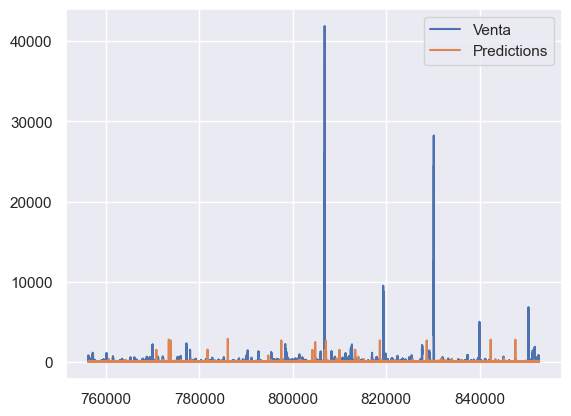

In [132]:
reverse_transformation_final[['Venta', 'Predictions']].plot()

In [151]:
num_sequences = len(test_sequence_generator)

flat_predictions = predictions[:num_sequences * sequence_length].flatten()

y_testing_flatten = y_testing[:len(flat_predictions)]



In [152]:
mae = mean_absolute_error(y_testing_flatten, flat_predictions)
mse = mean_squared_error(y_testing_flatten, flat_predictions)
rmse = np.sqrt(mse)

In [153]:
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 63.42474960505422
Root Mean Squared Error (RMSE): 244.8821457946517


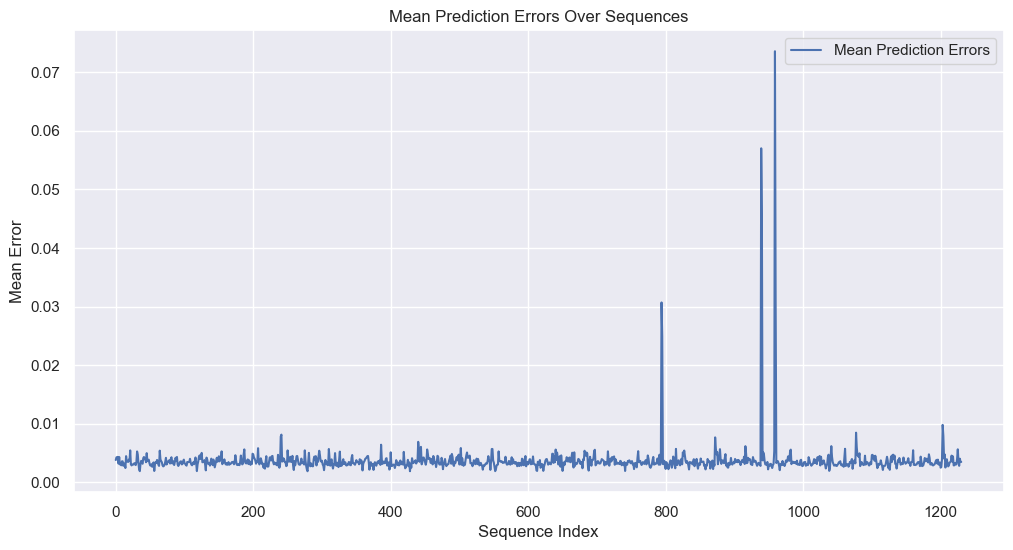

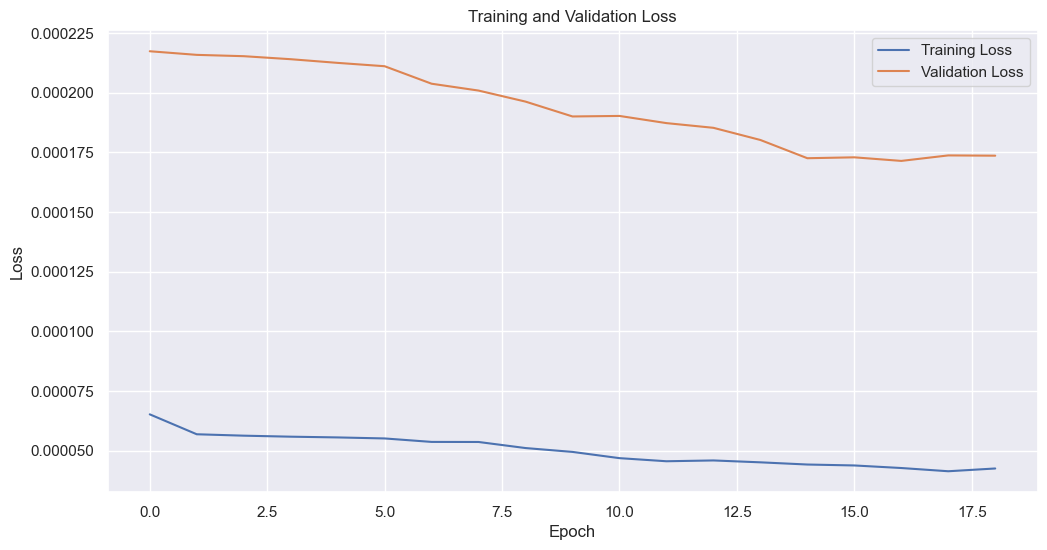

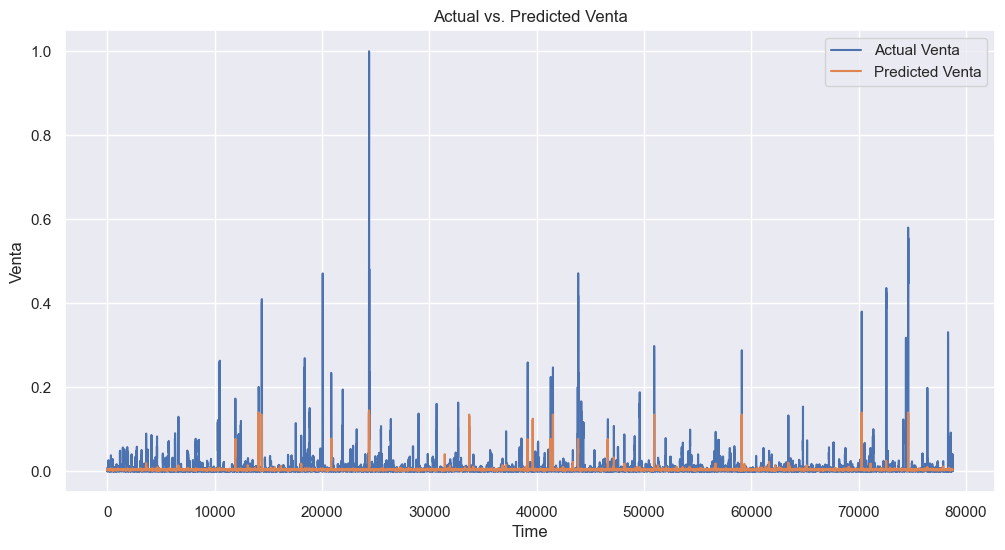

In [154]:

flat_predictions = flat_predictions.reshape(-1, sequence_length)
mean_sequence_errors = np.mean(flat_predictions, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(mean_sequence_errors, label='Mean Prediction Errors')
plt.xlabel('Sequence Index')
plt.ylabel('Mean Error')
plt.title('Mean Prediction Errors Over Sequences')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_testing_scaled, label='Actual Venta')
plt.plot(predictions, label='Predicted Venta')
plt.xlabel('Time')
plt.ylabel('Venta')
plt.title('Actual vs. Predicted Venta')
plt.legend()
plt.show()


In [156]:
model.save('trained_model_2.h5')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [155]:
reverse_transformation_final

,Tienda,Producto,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek,Venta,Predictions
756176,1,456,8,18,2021,0,1,1,0,0,2,150.559998,37.885283
756177,1,456,8,19,2021,0,1,1,0,0,3,109.814999,38.878882
756178,1,456,8,20,2021,0,1,1,0,0,4,121.660004,96.296229
756179,1,456,8,21,2021,0,1,1,0,0,5,117.970001,86.874746
756180,1,456,8,22,2021,0,1,1,0,0,6,139.000000,81.062249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
852732,1,2098857,10,10,2021,0,1,0,0,1,6,16.000000,56.370079
852733,1,2098857,10,11,2021,0,1,0,0,1,0,21.000000,50.932047
852734,1,2098857,10,12,2021,0,1,0,0,1,1,19.000000,53.636773
852735,1,2098857,10,13,2021,0,1,0,0,1,2,11.000000,52.897049


In [138]:
reverse_transformation_final.to_csv('./rawData/octubre15newPredictions.csv')